# Use daily total SIA to calculate max SIE for each year, and date (day of year) of that max. Plot as a scatterplot

### input/output filepaths

In [1]:
diri = '/g/data/jk72/wrh581/NSIDC/SIE_daily/'
prefix = 'NSIDC_SH_totalSIA_daily_'
iNam = 'SIE_cdr'
yrst = 1979
yren = 2024

diro = 'gd/Obs-seaice-analysis/plots/'
filo = 'NSIDC_SIEmax_vs_day-of-max.png'

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

### read data

In [3]:
yrstring = [str(yr) for yr in  np.arange(yrst,yren+1) ]        #string list of years
cmd = 'ls '+diri+prefix+'{'+','.join(yrstring)+'}*.nc'  #unix command
fpath = !$cmd

data = xr.open_mfdataset(fpath, parallel=True)



#.sel(**selcond)

#only read Aug-Oct for effieciency
SIE = data[iNam].isel(time = (data.time.dt.month.isin(range(8,11)))) 
SIE

<xarray.DataArray 'SIE_cdr' (time: 4201)> Size: 17kB
dask.array<getitem, shape=(4201,), dtype=float32, chunksize=(153,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 34kB 1979-08-01 1979-08-02 ... 2024-10-01
Attributes:
    units:      10^6 km^2
    long_name:  total sea ice extent

### get max SIE/day of max

In [4]:
#5-day runave
SIE = SIE.rolling(time=5, min_periods=5, center=True).mean()

#max at each year
SIEmax = SIE.groupby('time.year').max('time')

#time of maximum 
def find_max_day(group):
    return group.idxmax('time')

DATEmax = SIE.groupby('time.year').apply(find_max_day)
DATEmax = DATEmax.dt.dayofyear #convert to 'day of year'


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: merging cohorts
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False


### plot

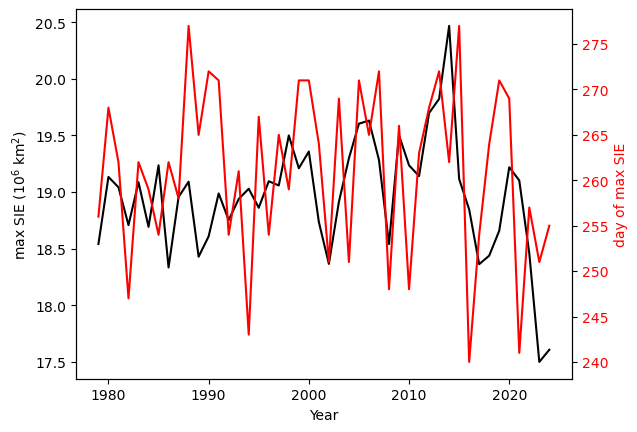

In [5]:
#timeplot with 2 y-axes

fig, ax1 = plt.subplots()

# Plot SIEmax on the first y-axis
ax1.plot(SIEmax['year'], SIEmax, 'k-', label='SIEmax')
ax1.set_xlabel('Year')
ax1.set_ylabel('max SIE (10$^6$ km$^2$)', color='k')
ax1.tick_params(axis='y', labelcolor='k')

# Create a second y-axis to plot SIEmax_day
ax2 = ax1.twinx()
ax2.plot(DATEmax['year'], DATEmax, 'r-', label='SIEmax Day')
ax2.set_ylabel('day of max SIE', color='r')
ax2.tick_params(axis='y', labelcolor='r')

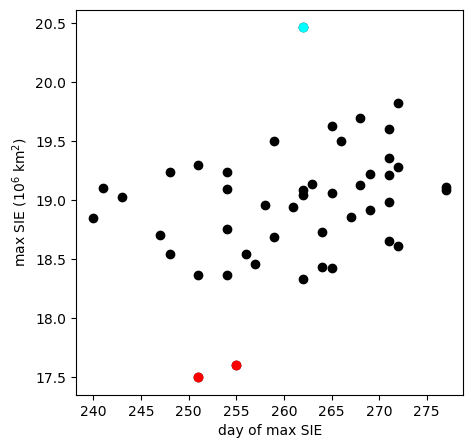

In [13]:
#scatterplot
yrsel = {'year' : slice(2023,2024) }

fig, ax = plt.subplots(figsize = (5,5))
ax.scatter(DATEmax, SIEmax,c='k')
ax.scatter(DATEmax.sel(**yrsel), SIEmax.sel(**yrsel),c='r')
ax.scatter(DATEmax.sel(year=2014), SIEmax.sel(year=2014),c='cyan')
ax.set_ylabel('max SIE (10$^6$ km$^2$)', color='k')
ax.set_xlabel('day of max SIE')

plt.savefig(diro+filo)